In [1]:
import uproot
import uproot_methods
import awkward
import matplotlib.pyplot as plt
import numpy as np
import time
import glob

In [2]:
files = glob.glob('/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_HT-100to200_TuneCP5_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50HT-100to200TuneCP513TeV-madgraphMLM-pythia8RunIIFall17MiniAODv2-PU201712Apr2018/190312_200205/0000/*.root')

In [3]:

jet_names = [b'FatJet_pt', b'FatJet_eta', b'FatJet_phi', b'FatJet_mass']
gen_names = [b'GenJetAK8_pt', b'GenJetAK8_eta', b'GenJetAK8_phi', b'GenJetAK8_mass']
#T = uproot.open("/uscms/home/rappocc/nobackup/analysis/B2G/CMSSW_10_2_9/src/Analysis/TTbarAllHad/test/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8_RunIIFall17NanoAODv4_example.root")["Events"]
rbins = [i * 0.01 for i in range(300)]
ptbins = [10,20,30,40,50,60,80,100,150,200,250,300,350,400,500,600,700,800,900,1000]
mbins = [0,5,10,15,20,25,30,35,40,50,60,70,80,90,100,150,300,1000]
print("ptbins, mbins =", len(ptbins), len(mbins))
hists = []
start_time = time.perf_counter()
nev = 0
for T in uproot.iterate(files, 'Events', jet_names + gen_names): #, entrysteps=10000):

    print ('Iterating nev = ', nev)
    Jet_pt,Jet_eta,Jet_phi,Jet_mass = [ T[i] for i in jet_names]
    GenJet_pt,GenJet_eta,GenJet_phi,GenJet_mass = [ T[i] for i in gen_names]


    jets = uproot_methods.TLorentzVectorArray.from_ptetaphim(Jet_pt, Jet_eta, Jet_phi, Jet_mass)
    genjets = uproot_methods.TLorentzVectorArray.from_ptetaphim(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)
    
    
    goodjets_index = jets.pt > 30.
    goodgens_index = genjets.pt > 10.
    goodjets = jets[goodjets_index]
    goodgens = genjets[goodgens_index]    
    
    pairing = goodjets.cross(goodgens, nested=True)
    metric = pairing.i0.delta_r(pairing.i1)
    index_of_minimized = metric.argmin()
    passes_cut = (metric[index_of_minimized] < 0.4)
    best_pairings_that_pass_cut = pairing[index_of_minimized][passes_cut]
    genrecos = best_pairings_that_pass_cut.flatten(axis=1)
    
    #ptresponse = genrecos.i0.pt / genrecos.i1.pt
    vals = np.array([genrecos.i1.pt.flatten(),
                       genrecos.i1.mass.flatten(),
                       genrecos.i0.pt.flatten(),
                       genrecos.i0.mass.flatten()
                      ]
                     )
    bins = (ptbins,mbins,ptbins,mbins)
    H,edges=np.histogramdd( vals.T, 
                           bins=bins)
    hists.append(H)
    nev += 1
    
cpu_time = time.perf_counter() - start_time
print ('Processing time: ', cpu_time, ',  nev: ', nev) 

ptbins, mbins = 20 18
Iterating nev =  0
Processing time:  0.6046857689980243 ,  nev:  1


In [4]:
# Set fonts (from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [5]:
#hist = sum( hists )
hist = hists[0]

In [6]:
print(hist.shape)

(19, 17, 19, 17)


In [7]:
def transform(i,j,k,l, s1, s2):
    return [i * s1 + j, k * s2 + l]

def make_2d_projection(H):
    nx = H.shape[0]
    ny = H.shape[1]
    H2 = np.zeros(( (nx-1)*(ny-1),(nx-1)*(ny-1)))
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nx-1):
                for l in range(ny-1):
                    x,y = transform(i,j,k,l,ny-1,ny-1)                
                    H2[x][y] = H[i][j][k][l]
                    
    return H2

In [8]:
H2 = make_2d_projection(H)


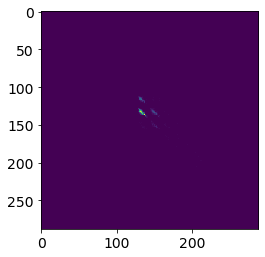

In [9]:
plt.imshow(H2)